In [18]:
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, average_precision_score , confusion_matrix
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
def pre_process(path, cut_off):
    col_names=['seqid', 'wstart','wend','ID']+list(range(80))
    df=pd.read_csv(path, sep='\t', header=None, names=col_names)
    el=df[df['ID'].str.contains('EL')]
    sl=df[df['ID'].str.contains('SL')]
    rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
    sl_rev=sl.loc[:,rev_idx]
    sl_rev.columns=col_names
    data=pd.concat([el, sl_rev]).assign(Y= lambda x: (~x['ID'].str.contains('ref')).astype(int))
    keep=data.loc[:,list(range(80))].sum(axis=1) >= cut_off
    data_exp=data[keep]
    bal=data_exp['Y'].value_counts().min()
    data_comp=pd.concat([data_exp[data_exp['Y']==1].sample(bal, random_state=420024), data_exp[data_exp['Y']== 0].sample(bal, random_state=420024)])
    return(data_comp)


def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def test_model(X,Y, model):
    X_test=X
    Y_test=Y
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    
    roc_auc=roc_auc_score(Y_test, Y_prob)
    cm=confusion_matrix(y_pred=Y_pred,y_true=Y_test)
    
    #pr_auc= average_precision_score(Y_test, Y_prob)
    print('confusion matrix\n')
    print(cm)
    print('classification_report\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    print('ROC-AUC: ' + str(roc_auc))
    #print('PR-AUC: ' + str(pr_auc))
    return(model)
os.environ['KMP_DUPLICATE_LIB_OK']='True'





def test_model_2(X,Y, model):
    X_test=X
    Y_test=Y
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    return(Y_test, Y_pred, Y_prob)
    


os.chdir('/Users/swamyvs/NIH/eyesplice_predictor/')

In [3]:
data_1=pre_process('cleaned_cov/HM7FMBBXX_16424750_S70_bp_features.tsv.gz',80)
data_2=pre_process('cleaned_cov/HM7MVBBXX_16424750_S72_bp_features.tsv.gz',80)
data_3=pre_process('cleaned_cov/HM7HWBBXX_16424750_S61_bp_features.tsv.gz',80)

Training a model on 1 sample , see how it generalizes to the others

In [4]:
x_cols=list(range(80))
X1=data_1.loc[:,x_cols]
Y1=data_1['Y']
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=.3)
model_1only=XGBClassifier(random_state=8967)
model_1only.fit(X1_train, Y1_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=8967,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

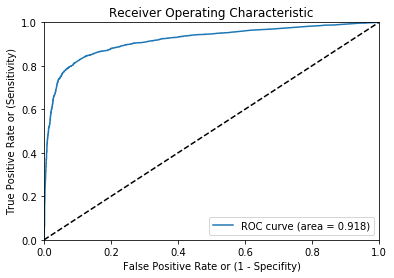

confusion matrix

[[4580  437]
 [ 980 4050]]
classification_report

              precision    recall  f1-score   support

           0       0.82      0.91      0.87      5017
           1       0.90      0.81      0.85      5030

    accuracy                           0.86     10047
   macro avg       0.86      0.86      0.86     10047
weighted avg       0.86      0.86      0.86     10047

ROC-AUC: 0.917757418019291


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=8967,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

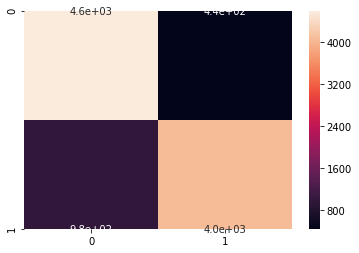

In [19]:
%matplotlib inline
test_model(X1_test, Y1_test, model_1only)

Testing on other samples

In [10]:
print(data_2.shape)
X2=data_2.loc[:,x_cols]
Y2=data_2['Y']
test_model(X2, Y2, model_1only)


(33302, 85)
confusion matrix

[[15110  1541]
 [ 3503 13148]]
classification_report

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     16651
           1       0.90      0.79      0.84     16651

   micro avg       0.85      0.85      0.85     33302
   macro avg       0.85      0.85      0.85     33302
weighted avg       0.85      0.85      0.85     33302

ROC-AUC: 0.9107097474220206
PR-AUC: 0.9235333753985255


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8967, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [11]:
print(data_3.shape)
X3=data_3.loc[:,x_cols]
Y3=data_3['Y']
test_model(X3, Y3, model_1only)

(35734, 85)
confusion matrix

[[15801  2066]
 [ 3497 14370]]
classification_report

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     17867
           1       0.87      0.80      0.84     17867

   micro avg       0.84      0.84      0.84     35734
   macro avg       0.85      0.84      0.84     35734
weighted avg       0.85      0.84      0.84     35734

ROC-AUC: 0.9099759107931844
PR-AUC: 0.9183182674019655


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=8967, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Now merging all three to see if we get better results 

In [ ]:
all_data=pd.concat([data_1, data_2, data_3])
all_data.shape

In [16]:
all_data['Y'].value_counts()
XA=all_data.loc[:,x_cols]
YA=all_data['Y']
XA_train, XA_test, YA_train, YA_test=train_test_split(XA, YA, test_size=.3)
model_all=XGBClassifier(random_state=3434)
model_all.fit(XA_train, YA_train)
test_model(XA_test, YA_test, model_all)


confusion matrix

[[13797  1520]
 [ 3181 12260]]
classification_report

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     15317
           1       0.89      0.79      0.84     15441

   micro avg       0.85      0.85      0.85     30758
   macro avg       0.85      0.85      0.85     30758
weighted avg       0.85      0.85      0.85     30758

ROC-AUC: 0.9119909079284355
PR-AUC: 0.9238342847326821


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=3434, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

So slightly better than the single sample one, probably no worth it.
